# Analyse des ventes de l'entreprise *"Rester livres"*

*Etude data - Projet 4 - Nalron (octobre 2019)* /
*ENSAE-ENSAI Formation Continue*

---

# Mission 2 : les analyses…

## Brief sur les variables des 3 dataframes

**Variable quantitative :**
- Les prix produits

**Variables qualitatives :**
- Les id (client_id, id_prod, session_id)
- Les dates de transactions (de 2021-03-01 à 2022-02-28)
- Le sexe des clients (f ou m)
- Les catégories produits (0, 1 ou 2)
 
**Afin de mieux comprendre les ventes, l'analyse portera principalement sur les dimensions suivantes :**

- L'évolution des ventes (Chiffre d'Affaires)
- Les prix produits pratiqués
- La répartition sectorielle (par Catégorie)
- La répartition démographique (par âge et sexe client)
- Le comportement client (fidélisation)
- Corrélation, lien(s) possible(s) entre les variables 

## Préparation des données transactionnelles produits 

In [24]:
# Jointure pour agréger les valeurs 'transactions' avec celles 'products' (méthode .merge())
df_transactions_products = pd.merge(df_transactions, df_products, on='id_prod', how='left')
df_transactions_products.head()

,id_prod,date,session_id,client_id,price,categ
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450,4.99,0.0
1,2_226,2022-02-03 01:55:53.276402,s_159142,c_277,65.75,2.0
2,1_374,2021-09-23 15:13:46.938559,s_94290,c_4270,10.71,1.0
3,0_2186,2021-10-17 03:27:18.783634,s_105936,c_4597,4.20,0.0
4,0_1351,2021-07-17 20:34:25.800563,s_63642,c_1242,8.99,0.0


In [25]:
# Vérification d'éventuelles valeurs manquantes (méthode .isnull())
df_transactions_products.isnull().sum()

id_prod         0
date            0
session_id      0
client_id       0
price         103
categ         103
dtype: int64

In [26]:
# Aucun id produit manquant, il est intéressant de détecter le ou les produits concernés par les valeurs manquantes
# Création d'un dataframe ciblant uniquement ces NaN
df_missing_values = df_transactions_products[df_transactions_products.categ.isnull() == True]

In [27]:
# Recherche du ou des produits concernés
df_missing_values.id_prod.unique()

array(['0_2245'], dtype=object)

*Seul le produit id 0_2245 est concerné par les valeurs manquantes.*

In [28]:
# Exactement 103 lignes non exploitables dans l'état pour le produit id 0_2245
# Il est préférable de les conserver en remplacant les prix NaN par le prix moyen
df_transactions_products['price'] = df_transactions_products.price.fillna(df_transactions_products.price.mean())

In [29]:
# Le produit id 0_2245 doit-être classifié en catégorie 0, il commence par "0_"
# Méthode .fillna() pour remplacer les NaN de la variable catégorie par 0
df_transactions_products['categ'] = df_transactions_products.categ.fillna(0)

In [30]:
# 22 individus restants sans date, sans session_id et sans client_id
# Il n'y pas de solution immédiate pour pouvoir obtenir des indications sur la date, la session…
# Il est préférable de les supprimer pour les exclure de l'analyse
df_transactions_products[df_transactions_products.date.isnull() == True]

,id_prod,date,session_id,client_id,price,categ


In [31]:
# Suppression des 22 dernières lignes avec valeurs manquantes (celles affichées ci-dessus)
df_transactions_products = df_transactions_products.dropna()

In [32]:
# Nouvelle vérification des valeurs manquantes, normalement les catégories sont désormais sans NaN
df_transactions_products.isnull().sum()

id_prod       0
date          0
session_id    0
client_id     0
price         0
categ         0
dtype: int64

## Analyse de l'évolution du chiffre d'affaires

In [33]:
# Agrégation des données transactionnelles par fréquence mensuelle (méthode .groupby())
df_transactions_months = df_transactions_products.groupby(pd.Grouper(key='date', freq='M')).sum().reset_index()

df_transactions_months['ventes_keuros'] = df_transactions_months.price / 1000
df_transactions_months = df_transactions_months[['date', 'ventes_keuros']]
df_transactions_months

,date,ventes_keuros
0,2021-03-31,479.466967
1,2021-04-30,473.221733
2,2021-05-31,489.505672
3,2021-06-30,481.378446
4,2021-07-31,480.967521
5,2021-08-31,479.460127
6,2021-09-30,502.977862
7,2021-10-31,319.280466
8,2021-11-30,513.062322
9,2021-12-31,523.058186


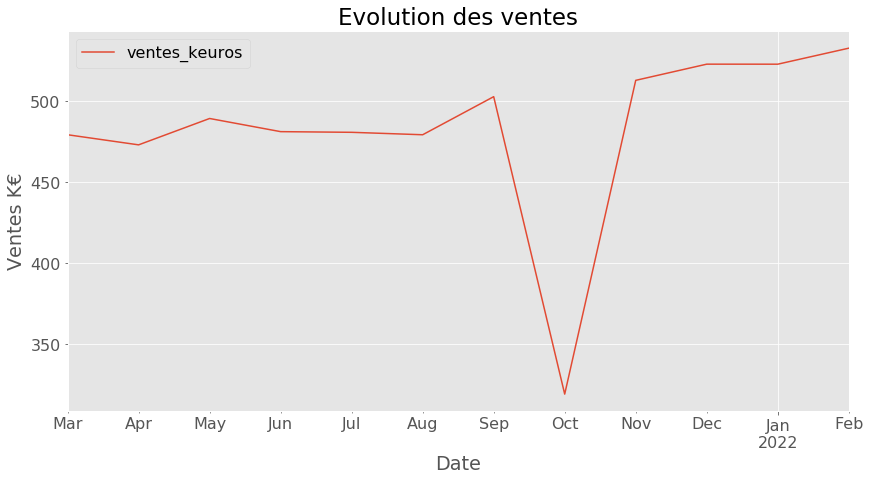

In [49]:
# Visualisation de l'évolution des ventes sur les 12 derniers mois
df_transactions_months.plot(x='date', y='ventes_keuros')

plt.title('Evolution des ventes')
plt.xlabel('Date')
plt.ylabel('Ventes K€')

plt.savefig("p4_graphic/evolution_ventes.png")
plt.show()

*Une baisse d'activité significative est enregistrée sur le mois d'octobre, mais pourquoi ?*

In [36]:
# Restriction selon les dates du mois d'octobre
transaction_october = len(df_transactions_products[(df_transactions_products.date > '2021-09-30') & \
                                                   (df_transactions_products.date < '2021-11-01')])
transaction_october

22895

In [37]:
# Restriction selon les dates du mois de septembre
transaction_september = len(df_transactions_products[(df_transactions_products.date > '2021-08-31') & \
                                                     (df_transactions_products.date < '2021-10-01')])
transaction_september

34086

*Il semble manquer des valeurs sur le mois d'octobre, la visualisation le montre, et le nombre de lignes identifiées sur la période semble le confirmer également. Une vérification supplémentaire est nécessaire.*

In [38]:
# Restriction par catégorie pour identifier les valeurs manquantes sur le mois d'octobre
df_transactions_products[(df_transactions_products.categ == 1) & (df_transactions_products.date > '2021-10-02') & \
                                                   (df_transactions_products.date < '2021-10-28')]

,id_prod,date,session_id,client_id,price,categ


*Aucune transaction sur les produits de catégorie 1 durant le mois d'octobre.*

Pour la suite de l'étude le mois d'octobre ne sera pas pris en compte, l'analyse se fera sur 11 mois au lieu de 12.

In [40]:
# Création (par restriction des dates)du dataframe 'df_transactionsv1' excluant les transactions du mois d'octobre
df_transactionsv1 =  df_transactions[(df_transactions.date <= '2021-09-30') | (df_transactions.date >= '2021-11-01')]

In [41]:
#Nouvelle jointure pour agréger les valeurs 'transactionsv1' avec celles 'products' (méthode .merge())
df_transactionsv1_products = pd.merge(df_transactionsv1, df_products, on='id_prod')
df_transactionsv1_products.head()

,id_prod,date,session_id,client_id,price,categ
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450,4.99,0
1,0_1483,2021-11-14 11:11:45.276771,s_119491,c_182,4.99,0
2,0_1483,2021-07-30 19:37:16.087057,s_69222,c_1196,4.99,0
3,0_1483,2021-03-30 14:18:13.403218,s_13545,c_2890,4.99,0
4,0_1483,2021-05-09 17:45:59.753345,s_32218,c_4690,4.99,0


*Pour la suite de l'étude les dataframes df_transactionsv1_products et df_transactionsv1 seront utilisés.*

## Analyse des prix pratiqués : variable '*price*' (*df_transactionsv1_products*)

### > Mesures de tendance centrale et dispersion des prix produits *(toutes catégories confondues)*

In [42]:
# Calcul de la Moyenne des prix produits vendus 
round(df_transactionsv1_products['price'].mean(), 2)

17.4

In [43]:
# Calcul de la Mediane des prix produits vendus
df_transactionsv1_products['price'].median()

13.99

In [44]:
# Calcul du Mode des prix produits vendus
df_transactionsv1_products['price'].mode()

0    15.99
dtype: float64

In [45]:
# Calcul de la Variance des prix produits vendus
round(df_transactionsv1_products['price'].var(ddof=0), 2)

320.02

In [46]:
# Calcul de l'écart type des prix produits vendus 
round(df_transactionsv1_products['price'].std(ddof=0), 2)

17.89

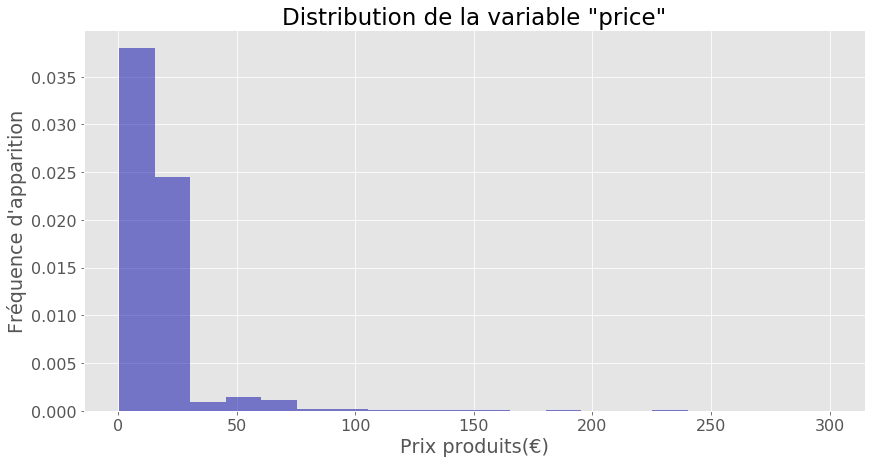

In [50]:
#Visualisation (Histogramme)de la distribution des prix produits
df_transactionsv1_products['price'].hist(color='#0504aa', alpha=0.5, density=True, bins=20)

plt.title('Distribution de la variable "price"')
plt.xlabel('Prix produits(€)')
plt.ylabel('Fréquence d\'apparition')

plt.savefig("p4_graphic/distribution_price.png")
plt.show()

*Plus bas nous verrons la distribution des prix produits par catégorie…*

### > Mesure de concentration des prix produits *(toutes catégories confondues)*

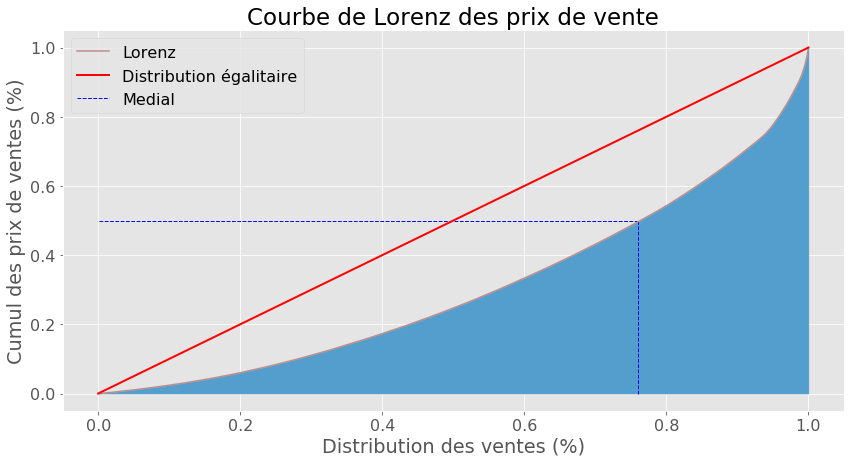

In [55]:
# Courbe de Lorenz sur la variables des prix
price = df_transactionsv1_products['price'].values
#Sélection du sous-échantillon de travail que l'on appelle price

# On place les observations dans une variable
lorenz_price = np.cumsum(np.sort(price)) / price.sum()
# Tri des individus dans l'ordre croissant des valeurs de la variable, 
# calcul de la somme cumulée et normalisation en divisant par la somme des observations

plt.plot(np.linspace(0,1,len(lorenz_price)), lorenz_price, drawstyle='steps-post', color='rosybrown', label='Lorenz')
plt.fill_between(np.linspace(0,1,len(lorenz_price)) ,lorenz_price , color='#539ecd')
plt.plot([0, 1], [0, 1], 'r-', lw=2, label='Distribution égalitaire')
plt.vlines(x=.76, ymin=0, ymax=.5, color='blue', linestyle='--', linewidth=1, label='Medial')
plt.hlines(xmin=.76, xmax=0, y=.5, color='blue', linestyle='--', linewidth=1)

plt.title('Courbe de Lorenz des prix de vente')
plt.xlabel("Distribution des ventes (%)")
plt.ylabel("Cumul des prix de ventes (%)")
plt.legend(loc="best")

plt.savefig("p4_graphic/lorenz_price.png")
plt.show()

*On constate que 76% des ventes représentent 50% du montant total des prix de vente. Ce n'est pas une égalité totale, mais acceptable dans notre contexte business.*

In [56]:
# Aire sous la courbe de Lorenz. La dernière valeur ne participe pas à l'aire, d'où "[:-1]"
aire_ss_courbe_price = lorenz_price[:-1].sum()/len(lorenz_price) 

# Aire entre la 1e bissectrice et la courbe de Lorenz
S = 0.5 - aire_ss_courbe_price 
gini_price = round(2*S, 2)

print("L'indice de Gini est égal à {}".format(gini_price))

L'indice de Gini est égal à 0.39


*Confirmation avec l'indice de Gini plus proche de 0 que de 1, les prix pratiqués ont tendance à être équitables.*

## Analyse sectorielle de l'activité : variable '*categ*' *(df_transactionsv1_products)*

In [57]:
# Représentation des effectifs par catégories de vente(méthode .value_counts())
effectif = df_transactionsv1_products['categ'].value_counts()
modalite = effectif.index #l'index de 'effectifs' contient les modalités

tab = pd.DataFrame(modalite, columns = ['categ']) #création du tableau à partir des modalités
tab["n"] = effectif.values
tab["f"] = tab["n"] / len(df_transactionsv1_products) #len(df_transactionsv1_products) renvoie la taille de l'échantillon
tab

,categ,n,f
0,0,189725,0.604557
1,1,107727,0.343271
2,2,16373,0.052172


In [58]:
# Fréquences cumulées
tab = tab.sort_values("categ") # tri des valeurs de la variable X (croissant)
tab["F"] = tab["f"].cumsum() # cumsum calcule la somme cumulée
tab

,categ,n,f,F
0,0,189725,0.604557,0.604557
1,1,107727,0.343271,0.947828
2,2,16373,0.052172,1.000000


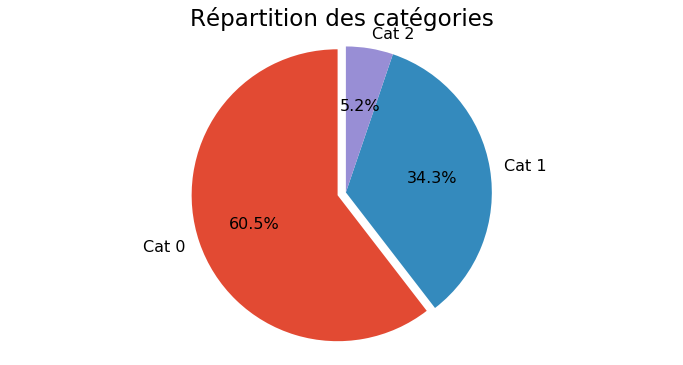

In [59]:
# Pie Chart pour représenter la part de chacune des catégories de vente
labels = 'Cat 0', 'Cat 1', 'Cat 2'
sizes = tab['f']
explode = (0.06, 0, 0)

fig1, ax1 = plt.subplots(figsize=(12,6))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=False, startangle=90)

ax1.axis('equal') 
plt.title('Répartition des catégories')
plt.savefig("p4_graphic/repartition_categories.png")
plt.show()

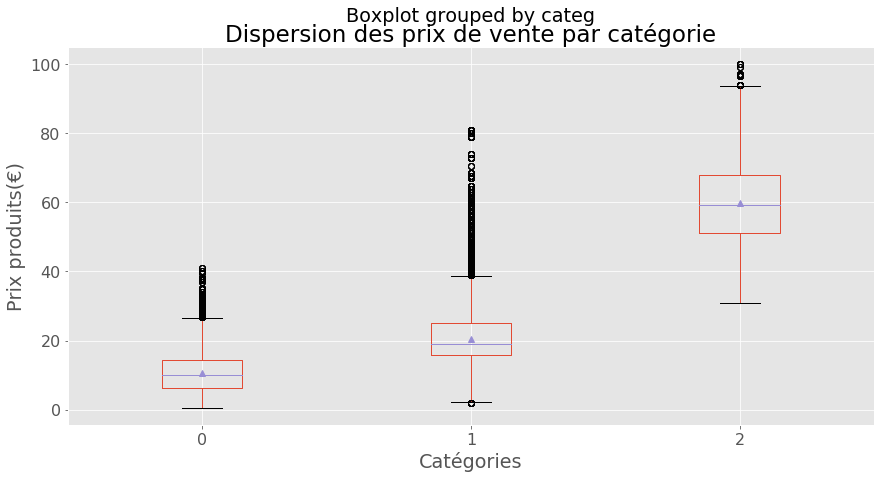

In [60]:
# Comparaison de distribution des prix produits par catégorie avec un boxplot
subset = df_transactionsv1_products[df_transactionsv1_products.price < 100]
subset.boxplot(column='price', by='categ', showmeans=True)

plt.title('Dispersion des prix de vente par catégorie')
plt.xlabel('Catégories')
plt.ylabel('Prix produits(€)')

plt.savefig("p4_graphic/dispersion_categories.png")
plt.show()

*La distribution des prix au sein de chacune des catégories n'est pas symétrique puisqu'elle ne présente pas la même forme de part et d’autre du centre de la distribution. Nous avons presque une égalité entre la Moyenne et la Médiane, mais le Mode est à chaque fois plus éloigné.*

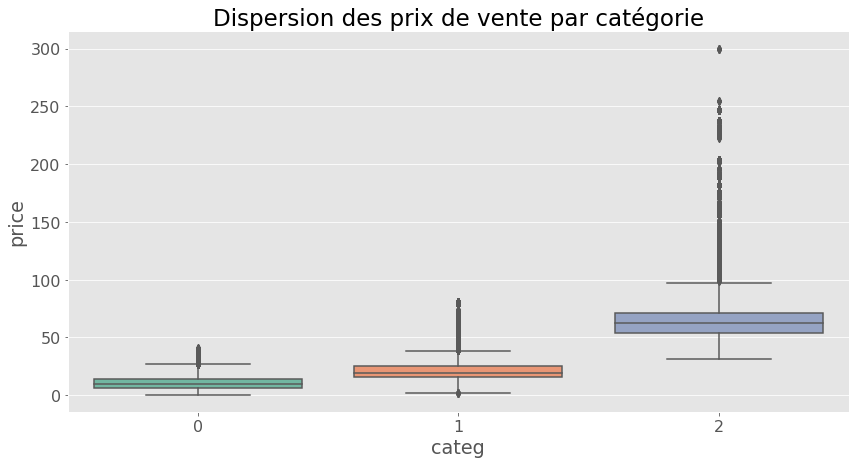

In [61]:
# Autre représentation possible avec Seaborn
sns.boxplot(x = 'categ', y = 'price', data = df_transactionsv1_products, palette="Set2")
plt.title('Dispersion des prix de vente par catégorie')
plt.show()

*Les 3 catégories n'ont pas les mêmes types (ou gamme)de produits. La catégorie 2 par exemple a un prix moyen proche des 60€ avec des outliers en queue de distribution jusqu'à 300€.*

### > Analyse des produits disponibles par catégorie

In [62]:
# Comptage des produits présents en catégorie 0
len(df_products[df_products.categ == 0].groupby('id_prod'))

2308

In [63]:
# Comptage des produits présents en catégorie 1
len(df_products[df_products.categ == 1].groupby('id_prod'))

739

In [64]:
# Comptage des produits présents en catégorie 2
len(df_products[df_products.categ == 2].groupby('id_prod'))

239

*Une offre produit qui reste cohérente devant les transactions enregistrées, avec visiblement peu de choix en catégorie 2.*

## Analyse démographique de l'activité 
### > Variable '*birth*' (*df_transactions_customers*)

In [65]:
# Préparation des données… Jointure des données transactionnelles et clients (méthode .merge())
df_transactionsv1_customers = pd.merge(df_transactionsv1, df_customers, on='client_id')
df_transactionsv1_customers.head()

,id_prod,date,session_id,client_id,sex,birth
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450,f,1977
1,1_596,2021-09-12 02:11:24.774608,s_88567,c_4450,f,1977
2,1_278,2021-09-10 15:09:01.555889,s_87835,c_4450,f,1977
3,0_1447,2021-05-25 00:17:56.841054,s_39094,c_4450,f,1977
4,0_1357,2021-08-01 10:43:25.039433,s_69919,c_4450,f,1977


In [66]:
# Ajout d'une colonne'age' pour faciliter l'analyse
df_transactionsv1_customers['age'] = 2022 - df_transactionsv1_customers.birth

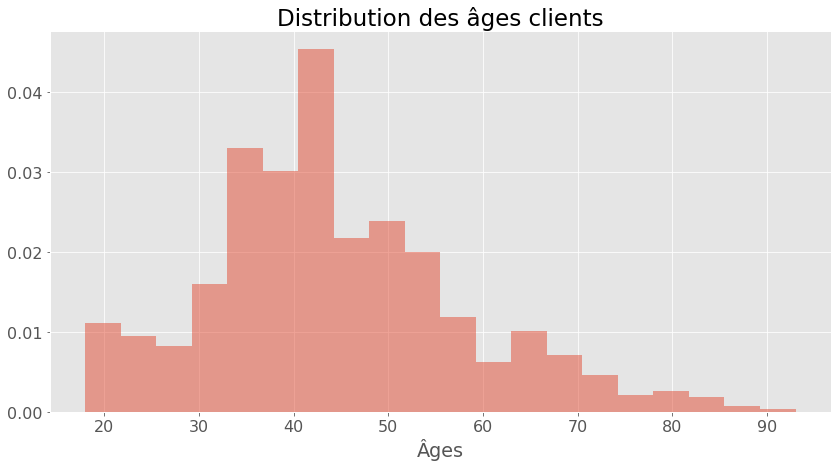

In [67]:
# Visualisation (Histogramme)de la distribution de l'âge clients
df_transactionsv1_customers['age'].hist(density=True, alpha=0.5, bins=20)

plt.xlabel('Âges')
plt.title('Distribution des âges clients')
plt.savefig("p4_graphic/distribution_ages_clients.png")
plt.show()

*La majeure partie des clients se concentrent entre 30 et 55 ans.*

### > Mesure de concentration des âges clients 

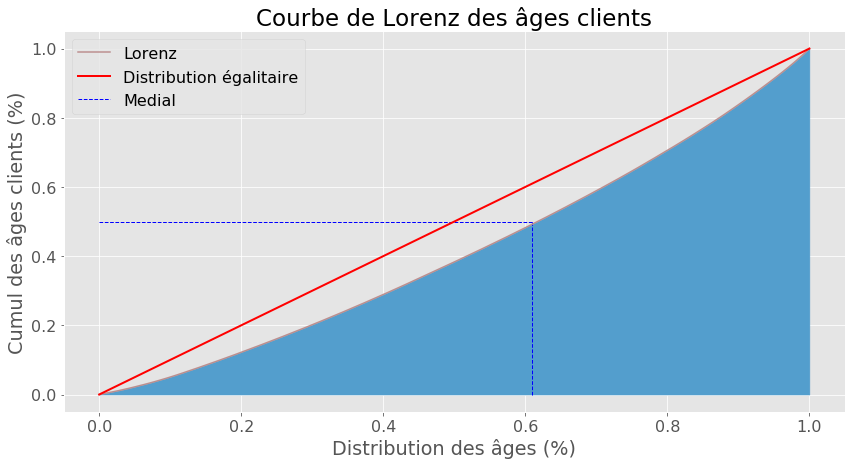

In [68]:
# Courbe de Lorenz sur la variable des âges 
ages = df_transactionsv1_customers['age'].values
# Sélection du sous-échantillon de travail que l'on appelle ages

# On place les observations dans une variable
lorenz_ages = np.cumsum(np.sort(ages)) / ages.sum()
# Tri des individus dans l'ordre croissant des valeurs de la variable, 
# calcul de la somme cumulée et normalisation en divisant par la somme des observations

plt.plot(np.linspace(0,1,len(lorenz_ages)), lorenz_ages, drawstyle='steps-post', color='rosybrown', label='Lorenz')
plt.fill_between(np.linspace(0,1,len(lorenz_ages)) ,lorenz_ages , color='#539ecd')
plt.plot([0, 1], [0, 1], 'r-', lw=2, label='Distribution égalitaire')
plt.vlines(x=.61, ymin=0, ymax=.5, color='blue', linestyle='--', linewidth=1, label='Medial')
plt.hlines(xmin=.61, xmax=0, y=.5, color='blue', linestyle='--', linewidth=1)

plt.title('Courbe de Lorenz des âges clients')
plt.xlabel("Distribution des âges (%)")
plt.ylabel("Cumul des âges clients (%)")

plt.legend(loc="best")
plt.savefig("p4_graphic/lorenz_age.png")
plt.show()

*On constate qu'environ 61% des âges clients représentent 50% du montant total des âges. C'est une égalité quasi parfaite, et nous pouvons le confirmer avec l'indice de Gini.*

In [69]:
# Aire sous la courbe de Lorenz. La dernière valeur ne participe pas à l'aire, d'où "[:-1]"
aire_ss_courbe_age = lorenz_ages[:-1].sum()/len(lorenz_ages) 

# Aire entre la 1e bissectrice et la courbe de Lorenz
S = 0.5 - aire_ss_courbe_age
gini_age = round(2*S, 2)

print("L'indice de Gini est égal à {}".format(gini_age))

L'indice de Gini est égal à 0.17


*Confirmation avec l'indice de Gini très proche de 0, les âges clients sont bien répartis, quasiment égalitaire dans notre contexte.*

### > Variable '*sex*' *(df_transactionsv1_customers)*

In [72]:
# Méthode .value_counts() pour avoir une idée rapide de la répartition homme/femme chez les clients
df_transactionsv1_customers['sex'].value_counts()

m    157458
f    156463
Name: sex, dtype: int64

In [75]:
# Méthode .pivot_table() pour affiner davantage la répartition des hommes et des femmes selon la catégorie d'achat
# Utilisation de df (étape suivante)obtenu par jointure avec df_customers et df_transactionsv1_products
fm = df.pivot_table(index='sex', columns='categ', values='price', aggfunc=sum).reset_index()

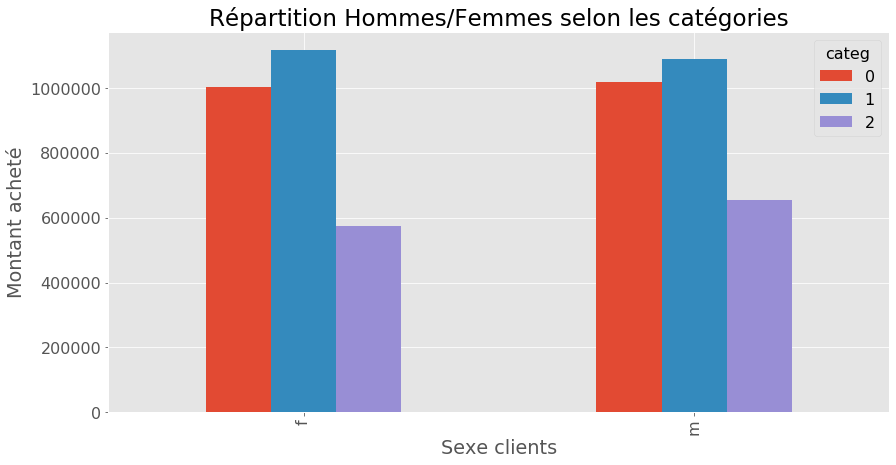

In [76]:
fm.plot(kind='bar', x='sex')

plt.title('Répartition Hommes/Femmes selon les catégories')
plt.xlabel('Sexe clients')
plt.ylabel('Montant acheté')

plt.savefig("p4_graphic/sex_categ.png")
plt.show()

*L'échantillon étudié ressort avec une égalité quasi parfaite entre les hommes et les femmes.*

## Analyse comportementale des clients

### > Analyse des transactions par client

In [74]:
# Préparation des données par jointure pour agréger les valeurs 'customers' avec celles 'transactionsv1_products'
df = pd.merge(df_customers, df_transactionsv1_products)
df.head()

,client_id,sex,birth,id_prod,date,session_id,price,categ
0,c_4410,f,1967,0_1420,2021-03-22 22:31:25.825764,s_10092,11.53,0
1,c_4410,f,1967,0_1390,2021-09-24 23:35:40.652636,s_94984,19.37,0
2,c_4410,f,1967,1_483,2021-03-13 21:35:55.949042,s_5913,15.99,1
3,c_4410,f,1967,1_267,2021-09-24 23:15:59.919591,s_94984,27.99,1
4,c_4410,f,1967,1_395,2021-09-24 23:57:35.138518,s_94984,28.99,1


In [77]:
# Agrégation des modalités de la variable 'client_id' (méthode .groupby())
# L'objectif est de comprendre l'action de ré-achat (ou non)des clients
fid_client = df.groupby('client_id').count().reset_index()
fid_client['nb_transac'] = fid_client.session_id
fid_client = fid_client[['client_id', 'nb_transac']]
fid_client.head()

,client_id,nb_transac
0,c_1,19
1,c_10,28
2,c_100,6
3,c_1000,53
4,c_1001,51


In [78]:
# Estimation des clients ayant passés plus d'une commande dans l'année
fid_client[fid_client['nb_transac'] > 1].shape[0]

8552

In [79]:
# Estimation des clients ayant passés une seule commande dans l'année
fid_client[fid_client['nb_transac'] == 1].shape[0]

46

In [80]:
# Estimation des clients ayant passés 2 commandes dans l'année
fid_client[fid_client['nb_transac'] == 2].shape[0]

99

*Excellente fidélisation des clients qui n'hésitent pas à revenir pour un nouvel achat.*

### > Analyse des centres d'intérêt client : "Catégorie d'affinité"

In [81]:
# Analyse des quantités de produits vendus selon les catéories
categ_prod = df.groupby('categ').price.count().reset_index()
categ_prod

,categ,price
0,0,189725
1,1,107727
2,2,16373


In [82]:
# Analyse du chiffre d'affaires selon les catégories
categ_sales = df.groupby('categ').price.sum().reset_index()
categ_sales

,categ,price
0,0,2.020531e+06
1,1,2.206702e+06
2,2,1.232057e+06


*La catégorie 2 ressort moins populaire que les deux autres, moins de quantités vendues, moins de chiffre d'affaires, mais un panier moyen qui reste beaucoup plus élevé.*

L'analyse va se poursuivre sur l'étude des liens éventuels entre les précédentes variables. L'enjeu est de comprendre les corrélations possibles ou non, de manière à pouvoir tirer des conclusions qui mènera l'entreprise à prendre des décisions stratégiques.

[Retour vers la page notebook précédente (analyse univariée / bivariée)](https://github.com/nalron/project_business_sales_analysis/blob/french_version/p4_notebook01.ipynb)

[Suite du projet par l'étude des corrélations…](https://github.com/nalron/project_business_sales_analysis/blob/french_version/p4_notebook03.ipynb)